Total features: 52
Highly correlated feature pairs (>0.9): 8
  qty <-> total_fees: 0.974
  gross_pnl <-> net_pnl: 1.000
  qty_sum <-> total_fees_sum: 0.984
  qty_mean <-> total_fees_mean: 0.940
  qty_count <-> total_fees_sum: 0.910


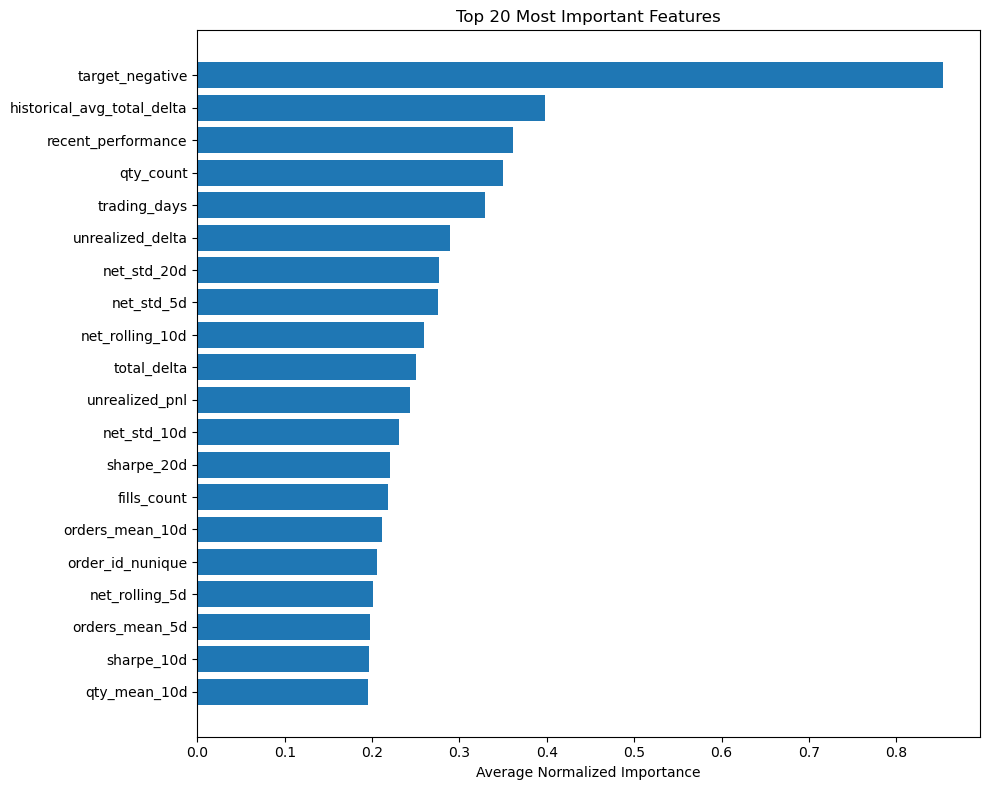


RECOMMENDED FEATURE SETS:

Minimal Set (Top 10):
  - target_negative
  - historical_avg_total_delta
  - recent_performance
  - qty_count
  - trading_days
  - unrealized_delta
  - net_std_20d
  - net_std_5d
  - net_rolling_10d
  - total_delta

Balanced Set (Top 20):
  - target_negative
  - historical_avg_total_delta
  - recent_performance
  - qty_count
  - trading_days
  - unrealized_delta
  - net_std_20d
  - net_std_5d
  - net_rolling_10d
  - total_delta
  - unrealized_pnl
  - net_std_10d
  - sharpe_20d
  - fills_count
  - orders_mean_10d
  - order_id_nunique
  - net_rolling_5d
  - orders_mean_5d
  - sharpe_10d
  - qty_mean_10d

Comprehensive Set (Top 30):
  - target_negative
  - historical_avg_total_delta
  - recent_performance
  - qty_count
  - trading_days
  - unrealized_delta
  - net_std_20d
  - net_std_5d
  - net_rolling_10d
  - total_delta
  - unrealized_pnl
  - net_std_10d
  - sharpe_20d
  - fills_count
  - orders_mean_10d
  - order_id_nunique
  - net_rolling_5d
  - orders_mean

In [6]:
# %% [markdown]
# # Feature Selection Analysis
# This notebook helps identify the most important features and reduce dimensionality

# %% Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression, SelectKBest, f_regression
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
import warnings

warnings.filterwarnings("ignore")

# %% Load engineered features
# Assuming you've already run the feature engineering
features_df = pd.read_csv("data/processed/features_df.csv")
feature_cols = [
    col
    for col in features_df.columns
    if col not in ["date", "symbol", "account_id", "trader_name", "target"]
]

print(f"Total features: {len(feature_cols)}")

# %% Check correlation matrix
# High correlation between features suggests redundancy
corr_matrix = features_df[feature_cols].corr()

# Find highly correlated pairs
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.9:
            high_corr_pairs.append(
                (corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j])
            )

print(f"Highly correlated feature pairs (>0.9): {len(high_corr_pairs)}")
for feat1, feat2, corr in high_corr_pairs[:5]:
    print(f"  {feat1} <-> {feat2}: {corr:.3f}")

# %% Feature importance using multiple methods
X = features_df[feature_cols]
y = features_df["target"]

# 1. Mutual Information
mi_scores = mutual_info_regression(X, y, random_state=42)
mi_df = pd.DataFrame({"feature": feature_cols, "mi_score": mi_scores}).sort_values(
    "mi_score", ascending=False
)

# 2. F-statistic
f_selector = SelectKBest(f_regression, k="all")
f_selector.fit(X, y)
f_scores = f_selector.scores_
f_df = pd.DataFrame({"feature": feature_cols, "f_score": f_scores}).sort_values(
    "f_score", ascending=False
)

# 3. Random Forest importance
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X, y)
rf_df = pd.DataFrame(
    {"feature": feature_cols, "rf_importance": rf.feature_importances_}
).sort_values("rf_importance", ascending=False)

# 4. LightGBM importance
lgb_model = lgb.LGBMRegressor(n_estimators=100, random_state=42, verbose=-1)
lgb_model.fit(X, y)
lgb_df = pd.DataFrame(
    {"feature": feature_cols, "lgb_importance": lgb_model.feature_importances_}
).sort_values("lgb_importance", ascending=False)

# %% Combine rankings
importance_df = (
    mi_df.merge(f_df, on="feature")
    .merge(rf_df, on="feature")
    .merge(lgb_df, on="feature")
)

# Normalize scores to 0-1
for col in ["mi_score", "f_score", "rf_importance", "lgb_importance"]:
    importance_df[f"{col}_norm"] = importance_df[col] / importance_df[col].max()

# Average normalized scores
importance_df["avg_importance"] = importance_df[
    ["mi_score_norm", "f_score_norm", "rf_importance_norm", "lgb_importance_norm"]
].mean(axis=1)
importance_df = importance_df.sort_values("avg_importance", ascending=False)

# %% Visualize top features
top_n = 20
top_features = importance_df.head(top_n)

fig, ax = plt.subplots(figsize=(10, 8))
y_pos = np.arange(len(top_features))

ax.barh(y_pos, top_features["avg_importance"])
ax.set_yticks(y_pos)
ax.set_yticklabels(top_features["feature"])
ax.invert_yaxis()
ax.set_xlabel("Average Normalized Importance")
ax.set_title(f"Top {top_n} Most Important Features")
plt.tight_layout()
plt.show()

# %% Print recommended features
print("\nRECOMMENDED FEATURE SETS:")
print("=" * 50)

print("\nMinimal Set (Top 10):")
for feat in importance_df.head(10)["feature"]:
    print(f"  - {feat}")

print("\nBalanced Set (Top 20):")
for feat in importance_df.head(20)["feature"]:
    print(f"  - {feat}")

print("\nComprehensive Set (Top 30):")
for feat in importance_df.head(30)["feature"]:
    print(f"  - {feat}")

# %% Check feature stability across traders
# Features that vary a lot between traders might not generalize well
feature_cv = {}
for feat in feature_cols:
    trader_stds = features_df.groupby("account_id")[feat].std()
    feature_cv[feat] = trader_stds.mean() / (features_df[feat].mean() + 1e-8)

cv_df = pd.DataFrame(
    {"feature": list(feature_cv.keys()), "cv": list(feature_cv.values())}
).sort_values("cv", ascending=False)

print("\nMost variable features across traders:")
for _, row in cv_df.head(10).iterrows():
    print(f"  {row['feature']}: CV = {row['cv']:.3f}")

# %% Save feature importance analysis
importance_df.to_csv("data/processed/feature_importance.csv", index=False)
print("\nFeature importance saved to data/processed/feature_importance.csv")